# NTF Value Prediction (CSCI-4850 Project)

## Setup

In [138]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from random import randint
import os
from PIL import Image
import json
import urllib
%matplotlib inline

In [139]:
ETH_API = 'https://api.coinbase.com/v2/exchange-rates?currency=ETH'

ETH_SYM = 'Ξ'
USD_SYM = '$'
BTC_SYM = '₿'

with urllib.request.urlopen(ETH_API) as data:
    C_EXCHANGE = json.load(data)['data']['rates']

def exchange(amt: float, frm: str, to: str = None):
    if to is None:
        return amt * float(C_EXCHANGE[frm])
    else:
        return amt / float(C_EXCHANGE[frm]) * float(C_EXCHANGE[to])

def dollars(val: float):
    return f'{USD_SYM} {val:,.2f}'

def eths(val: float):
    return f'{val:,.4f} {ETH_SYM}'

def coins(val: float):
    return f'{val:,.4f} {BTC_SYM}'

print(f"current rate ({ETH_SYM}->{USD_SYM}) {dollars(exchange(1.0, 'USD'))}")
print(f"current rate ({USD_SYM}->{ETH_SYM}) {eths(exchange(1.0, 'USD', 'ETH'))}")

print(f"current rate ({ETH_SYM}->{BTC_SYM}) {coins(exchange(1.0, 'BTC'))}")
print(f"current rate ({BTC_SYM}->{ETH_SYM}) {eths(exchange(1.0, 'BTC', 'ETH'))}")

current rate (Ξ->$) $ 2,875.17
current rate ($->Ξ) 0.0003 Ξ
current rate (Ξ->₿) 0.0736 ₿
current rate (₿->Ξ) 13.5953 Ξ


In [140]:
acceptable = ('.jpg','.jpeg','.bmp','.png')

preferred_size = (128, 128)

X = []
Y1 = []
Y2 = []

for root, dirs, files in os.walk("./Nft dataset"):
    for name in filter(lambda x: x.endswith(acceptable), files):
        full_path = os.path.join(root, name)
        print(f'found {repr(full_path)}')
        temp = Image.open(full_path)
        print(f'\timage dimensions: {temp.size}')
        if temp.size != preferred_size:
            print(f'\tresizing...')
            temp = temp.resize(preferred_size, Image.LANCZOS)
            print(f'\tnew image dimensions: {temp.size}')
        temp = temp.convert("RGB") 
        arr = np.array(temp)
        print(f'\tarray shape: {arr.shape}')
        X.append(arr)
        val = float(name.rsplit('.', 1)[0].rsplit(' ', 1)[0])
        print(f'\tvalue: {eths(val)}')
        Y1.append(val)
        Y2.append(0.0)
        print()

X = np.array(X)
Y1 = np.array(Y1)
Y2 = np.array(Y2)
        
print(X.shape)
print(Y1.shape)
print(Y2.shape)

found './Nft dataset/1.169.png'
	image dimensions: (286, 286)
	resizing...
	new image dimensions: (128, 128)
	array shape: (128, 128, 3)
	value: 1.1690 Ξ

found './Nft dataset/0.2987.png'
	image dimensions: (286, 286)
	resizing...
	new image dimensions: (128, 128)
	array shape: (128, 128, 3)
	value: 0.2987 Ξ

found './Nft dataset/7.02.png'
	image dimensions: (600, 600)
	resizing...
	new image dimensions: (128, 128)
	array shape: (128, 128, 3)
	value: 7.0200 Ξ

found './Nft dataset/12.25.png'
	image dimensions: (286, 286)
	resizing...
	new image dimensions: (128, 128)
	array shape: (128, 128, 3)
	value: 12.2500 Ξ

found './Nft dataset/2.498.png'
	image dimensions: (286, 286)
	resizing...
	new image dimensions: (128, 128)
	array shape: (128, 128, 3)
	value: 2.4980 Ξ

found './Nft dataset/10.5.png'
	image dimensions: (286, 286)
	resizing...
	new image dimensions: (128, 128)
	array shape: (128, 128, 3)
	value: 10.5000 Ξ

found './Nft dataset/6.5.png'
	image dimensions: (286, 286)
	resizing

In [141]:
class ModelInfo:
    def __init__(self, weights, epochs=None):
        self.weights = weights
        self.epochs = epochs

    def load_model(self, model):
        model.set_weights(self.weights)
        
    def store_model(self, model, epochs=None):
        self.epochs = epochs if epochs is not None else self.epochs
        self.weights = model.get_weights()

class ModelHistory:
    def __init__(self):
        self.history = []
    
    def __iter__(self):
        return iter(self.history)
    
    def stash_model(self, model, epochs=None):
        self.history.append(ModelInfo(model.get_weights(), epochs))
        
def extend_history(old=None, new=None):
    if old is None:
        return new
    else:
        oh, nh = old.history, new.history
        for key in nh:
            if key in oh:
                oh[key].extend(nh[key])
            else:
                oh[key] = list(nh[key])
        return old

In [142]:
history = None
model_history = ModelHistory()

## Model Creation

Model: "NFT_Valuator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
First_Convolution (Conv2D)      (None, 121, 121, 128 24704       Input_Layer[0][0]                
__________________________________________________________________________________________________
Second_Convolution (Conv2D)     (None, 116, 116, 64) 294976      First_Convolution[0][0]          
__________________________________________________________________________________________________
Third_Convolution (Conv2D)      (None, 113, 113, 32) 32800       Second_Convolution[0][0]         
_______________________________________________________________________________________

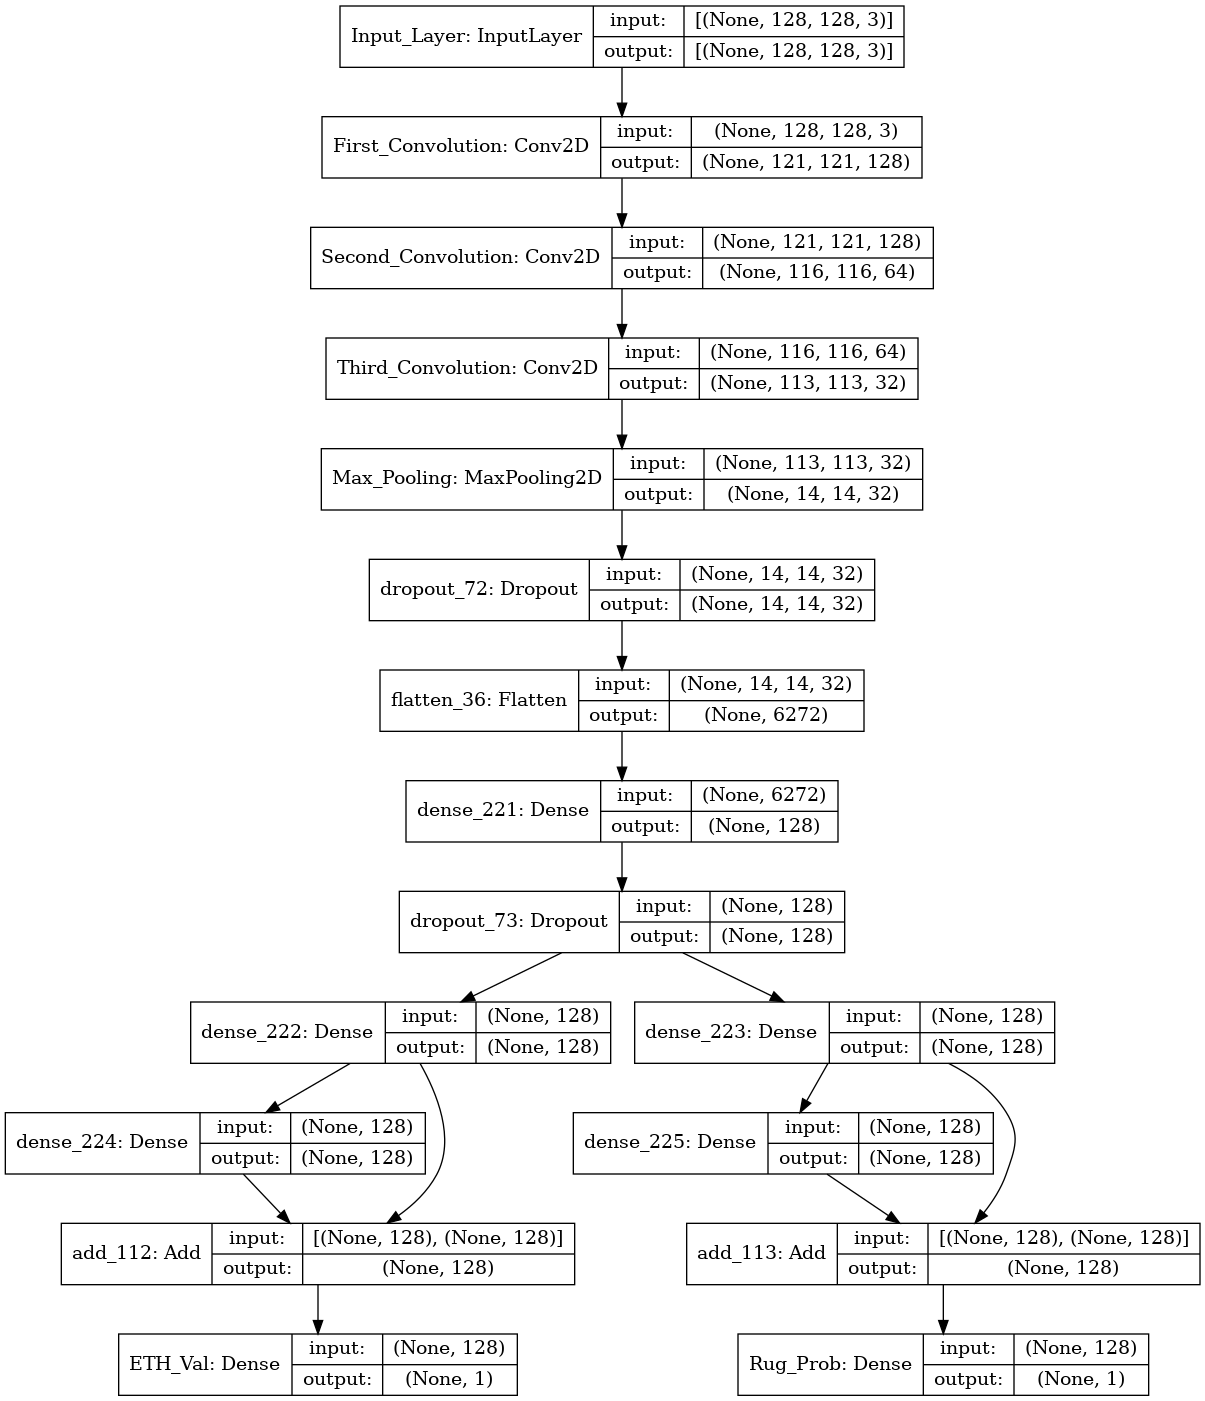

In [143]:
x = keras.layers.Input(X.shape[1:], name="Input_Layer")
y = x
y = keras.layers.Conv2D(128, kernel_size=(8,8), activation='relu', name="First_Convolution")(y)
y = keras.layers.Conv2D(64, kernel_size=(6,6), activation='relu', name="Second_Convolution")(y)
y = keras.layers.Conv2D(32, kernel_size=(4,4), activation='relu', name="Third_Convolution")(y)
y = keras.layers.MaxPooling2D(pool_size=(8,8), name="Max_Pooling")(y)
y = keras.layers.Dropout(0.05)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dropout(0.125)(y)
z = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dense(128, activation='relu')(y)

stack = 1
for _ in range(stack):
    a = keras.layers.Dense(128, activation='relu')(z)
    b = keras.layers.Dense(128, activation='relu')(y)
    c = keras.layers.Add()([a, z])
    d = keras.layers.Add()([b, y])
    z, y = c, d
# y = keras.layers.LayerNormalization()(y)
# Output Logits (10)
a = keras.layers.Dense(1, activation='relu', name="ETH_Val")(z) # Ethereum value of the NFT
y = keras.layers.Dense(1, activation='sigmoid', name="Rug_Prob")(y) # Whether or not the NFT will "rug" (scam its buyers)
z = a
model = keras.Model(x,[z, y],name="NFT_Valuator")
generator = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=5,
    zoom_range=0.1,
    horizontal_flip=True
)
model.compile(
    loss={'ETH_Val': keras.losses.MeanSquaredError(), 'Rug_Prob': keras.losses.BinaryCrossentropy()},
    optimizer=keras.optimizers.Adam(),
    metrics={'ETH_Val': keras.metrics.MeanSquaredError(), 'Rug_Prob': keras.metrics.BinaryAccuracy()}
)
model.summary()
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [144]:
model.save("NFTValuator")

2022-04-27 22:46:14.495369: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: NFTValuator/assets


INFO:tensorflow:Assets written to: NFTValuator/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Training

In [146]:
model = keras.models.load_model("NFTValuator")

In [129]:
batch_size = 30
epochs = 20
trials = 10

hr_w = 80
hr = '-' * hr_w

for t in range(trials):
    print(hr)
    print(f'TRIAL {t+1:,}'.center(hr_w))
    print(hr)
    history = extend_history(
        history, 
        model.fit(
            X, [Y1, Y2],
            batch_size=batch_size,
            epochs=epochs,
            verbose=1
        )
    )
    model_history.stash_model(model, epochs)

--------------------------------------------------------------------------------
                                    TRIAL 1                                     
--------------------------------------------------------------------------------
Epoch 1/2
4/4 [==============================] - 26s 6s/step - loss: 0.6772 - ETH_Val_loss: 0.0000e+00 - Rug_Prob_loss: 0.6772 - ETH_Val_mean_squared_error: 0.0000e+00 - Rug_Prob_binary_accuracy: 1.0000
Epoch 2/2
4/4 [==============================] - 26s 6s/step - loss: 0.6752 - ETH_Val_loss: 0.0000e+00 - Rug_Prob_loss: 0.6752 - ETH_Val_mean_squared_error: 0.0000e+00 - Rug_Prob_binary_accuracy: 1.0000
--------------------------------------------------------------------------------
                                    TRIAL 2                                     
--------------------------------------------------------------------------------
Epoch 1/2
4/4 [==============================] - 24s 6s/step - loss: 0.6733 - ETH_Val_loss: 0.0000e+00 - Rug

In [ ]:
model.save("NFTValuator")

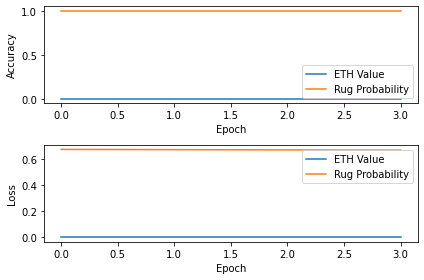

In [130]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['ETH_Val_mean_squared_error'])
plt.plot(history.history['Rug_Prob_binary_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ETH Value','Rug Probability'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['ETH_Val_loss'])
plt.plot(history.history['Rug_Prob_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ETH Value','Rug Probability'],loc='upper right')
plt.tight_layout()
plt.show()

----
## Testing the Model

This step is covered in [Project_Demo.ipynb](../Project_Demo.ipynb)